# Lab 6.3: Fashion MNIST dataset

This dataset uses tf.keras (high level) API to run the fashion MNIST dataset.

This dataset is similar to the MNIST but it uses fashion images.


In [16]:
%matplotlib inline

import tensorflow as tf
from zoo import init_nncontext
from zoo.pipeline.api.net import TFOptimizer, TFDataset
from bigdl.optim.optimizer import *
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from bigdl.dataset import mnist
from bigdl.dataset.transformer import *

sc = init_nncontext()



max_epoch = 3
data_num = 6000
val_num = 600



# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)


x_train_rdd = sc.parallelize(x_train[:data_num])
y_train_rdd = sc.parallelize(y_train[:data_num])
x_test_rdd = sc.parallelize(x_test[:data_num])
y_test_rdd = sc.parallelize(y_test[:data_num])
training_rdd = x_train_rdd.zip(y_train_rdd)
testing_rdd = x_test_rdd.zip(y_test_rdd)


x_train shape: (60000, 28, 28) y_train shape: (60000,)


In [17]:
x_train_rdd.count()

6000

In [18]:
# Print training set shape - note there are 60,000 training data of image size of 28x28, 60,000 train labels)
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training and test datasets
print(x_train.shape[0], 'train set')
print(x_test.shape[0], 'test set')

# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

# Image index, you can pick any number between 0 and 59,999
img_index = 5
# y_train contains the lables, ranging from 0 to 9
label_index = y_train[img_index]
# Print the label, for example 2 Pullover
#print ("y = " + str(label_index) + " " + str(fashion_mnist_labels[label_index]))
# # Show one of the images from the training dataset
#plt.imshow(x_train[img_index])


x_train shape: (60000, 28, 28) y_train shape: (60000,)
60000 train set
10000 test set


In [19]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[val_num:], x_train[:val_num] 
(y_train, y_valid) = y_train[val_num:], y_train[:val_num]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')


x_train shape: (59400, 28, 28, 1) y_train shape: (59400, 10)
59400 train set
600 validation set
10000 test set


In [20]:
dataset = TFDataset.from_rdd(training_rdd,
                             names=["features", "labels"],
                             shapes=[[28, 28, 1], []],
                             types=[tf.float32, tf.int32],
                             batch_size=280,
                             val_rdd=testing_rdd
                             )




In [21]:

data = Input(shape=[28, 28, 1])

x = Flatten()(data)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=data, outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

optimizer = TFOptimizer.from_keras(model, dataset)

optimizer.set_train_summary(TrainSummary("/tmp/fashion-mnist_log", "mnist"))
optimizer.set_val_summary(ValidationSummary("/tmp/fashion-mnist_log", "mnist"))
# kick off training
optimizer.optimize(end_trigger=MaxEpoch(max_epoch))

model.save_weights("/tmp/fashion-mnist_keras.h5")



creating: createRMSprop
creating: createClassNLLCriterion
creating: createLoss
creating: createZooKerasSparseCategoricalAccuracy
INFO:tensorflow:Froze 6 variables.
INFO:tensorflow:Converted 6 variables to const ops.
creating: createTFTrainingHelper
creating: createTFValidationMethod
creating: createTFValidationMethod
creating: createIdentityCriterion
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTrainSummary
creating: createValidationSummary
creating: createMaxEpoch


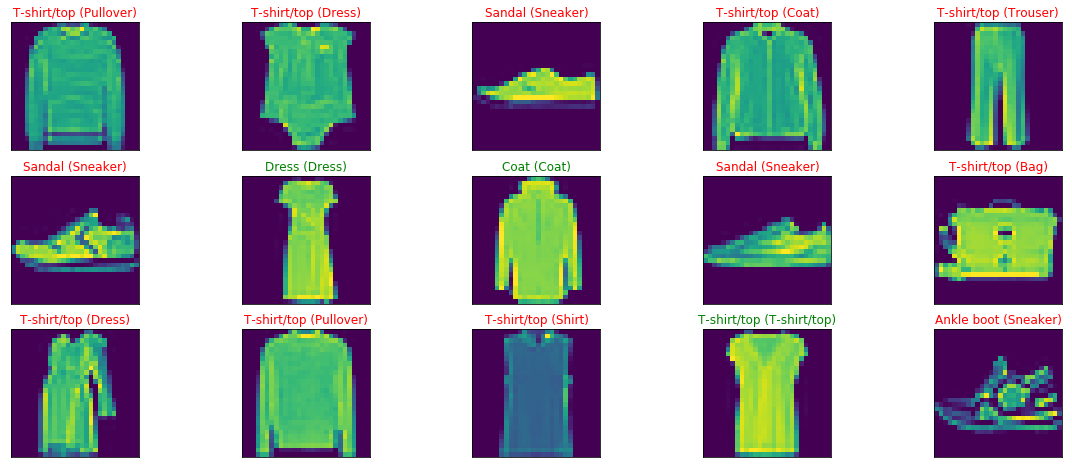

In [22]:
import matplotlib.pyplot as plt

y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))